In [20]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)

In [4]:
def run_command(cmd):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(cmd)

In [5]:
def show_tables(q):
    run_query(q)

# Selecting Albums to Purchase

In [6]:
albums_to_purchase = '''
    WITH usa_tracks_sold AS
           (
            SELECT il.* FROM invoice_line il
            INNER JOIN invoice i ON il.invoice_id = i.invoice_id
            INNER JOIN customer c ON i.customer_id = c.customer_id
            WHERE c.country = "USA"
           )

        SELECT
            g.name genre,
            COUNT(uts.invoice_line_id) tracks_sold,
            CAST(COUNT(uts.invoice_line_id) AS float) / (SELECT COUNT(*) FROM usa_tracks_sold) percentage_sold
        FROM usa_tracks_sold uts
        INNER JOIN track t ON t.track_id = uts.track_id
        INNER JOIN genre g ON g.genre_id = t.genre_id
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


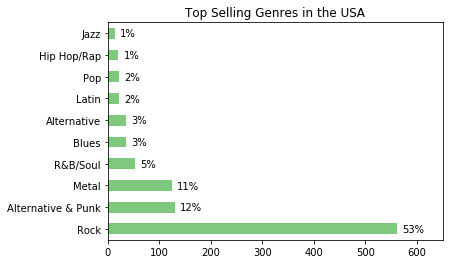

In [7]:
genre_sales_usa  = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 650),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Top 10 selling genres in the USA. As can be seen here, Rock is the most popular music purchases in the United States. Rock music accounts for 53% of the total sales.

# Analyzing Employee Sales Performance

In [16]:
q = """
    SELECT  e.first_name || ' ' || e.last_name AS support_rep,
            e.hire_date,
            SUM(total) sales
    FROM employee e, customer c, invoice i
    WHERE e.employee_id = c.support_rep_id
    AND c.customer_id = i.customer_id
    GROUP BY 1, 2
    """
sales_performance_by_emp = run_query(q)
sales_performance_by_emp

,support_rep,hire_date,sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


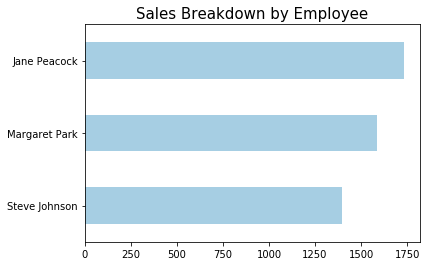

In [17]:
sales_performance_by_emp.sort_values('sales', inplace=True)
sales_performance_by_emp.set_index("support_rep", drop=True, inplace=True)
sales_performance_by_emp.plot.barh(legend=False, colormap=plt.cm.Paired)
plt.title('Sales Breakdown by Employee', size=15)
plt.ylabel('')
plt.show()

# Analyzing Sales by Country

In [18]:
sales_by_country = """
    WITH cte AS (
        SELECT country, 
                number_of_customers, 
                total_value_of_sales,
                round(total_value_of_sales / number_of_customers, 2) AS 
                average_sales_per_customer,
                round(total_value_of_sales / number_of_invoices, 2) AS
                average_order_value,
                CASE WHEN number_of_customers = 1 THEN 1
                ELSE 0 END AS condition
        FROM (
            SELECT country, 
                    COUNT(distinct c.customer_id) AS number_of_customers, 
                    SUM(i.total) AS total_value_of_sales,
                    COUNT(distinct i.invoice_id) AS number_of_invoices
            FROM customer c
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
            GROUP BY 1
            ) subq2
    ),

    cte2 AS (
        SELECT country, 
                number_of_customers, 
                total_value_of_sales,
                round(total_value_of_sales / number_of_customers, 2) AS 
                average_sales_per_customer,
                average_order_value,
                condition
        FROM cte
        WHERE condition = 0

        UNION

        SELECT 'Other' AS country,
                SUM(number_of_customers) AS number_of_customers,
                SUM(total_value_of_sales) AS total_value_of_sales,
                SUM(average_sales_per_customer) AS average_sales_per_customer,
                average_order_value,
                condition
        FROM cte
        WHERE condition = 1

        ORDER BY condition, number_of_customers DESC
    )

    SELECT country, 
            number_of_customers, 
            total_value_of_sales,
            average_order_value,
            average_sales_per_customer
            
    FROM cte2
    """

run_query(sales_by_country)

,country,number_of_customers,total_value_of_sales,average_order_value,average_sales_per_customer
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,United Kingdom,3,245.52,8.77,81.84
6,Czech Republic,2,273.24,9.11,136.62
7,India,2,183.15,8.72,91.57
8,Portugal,2,185.13,6.38,92.57
9,Other,15,1094.94,7.52,1094.94


# Visualizing Sales by Country

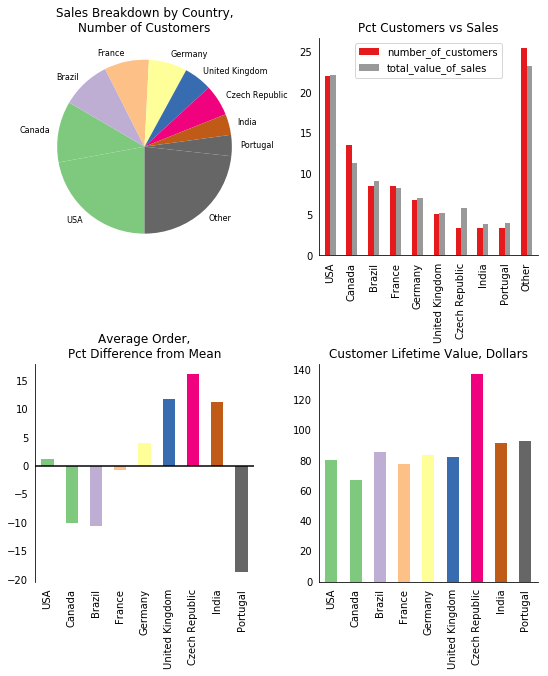

In [19]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_value_of_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["number_of_customers","total_value_of_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["average_sales_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

From the above charts and graphs, there are opportunities in the following countries: Czech Republic, United Kingdom and India.

These three countries have relatively small sales percentages, but very large average order from the mean. Also, the number of customers is far less than the total_sales, which indicates revenue generated by one customer is large and there could be potential market penetration opportunities in these three countries to attract more sales. However, one thing to keep in mind is that the sample is relatively small. It would be wise to run some small test campaigns to collect more data and analyze the true trends.